In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [5]:
neurons = [100, 200, 300, 400, 500]
rln = pd.read_pickle("data/RL_n_carrabin_feb7rln_dynamics.pkl")
human = pd.read_pickle("data/carrabin.pkl")
rln['neurons'] = 'RLn'
human['neurons'] = 'human'
dfs = [human, rln]
for n in neurons:
    nef = pd.read_pickle(f"data/NEF_RL_carrabin_rln{n}neurons_dynamics.pkl")
    nef['neurons'] = str(n)
    dfs.append(nef)
combined = pd.concat(dfs, ignore_index=True)
combined['alpha'] = None

In [7]:
for sid in human['sid'].unique():
    print(sid)
    subdata = combined.query("sid==@sid")
    for i, row in subdata.iterrows():
        mt = row['type']
        sid = row['sid']
        trial = row['trial']
        stage = row['stage']
        response = row['response']
        neurons = row['neurons']
        if stage>1:
            stage_old = stage - 1
            # print(mt, sid, trial, stage, stage_old)
            response_old = subdata.query("type==@mt & neurons==@neurons & trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
            delta = response_old - response
            color = human.query("sid==@sid & trial==@trial & stage==@stage")['color'].to_numpy()[0]
            prediction_error = color - response_old
            alpha = np.abs(delta / prediction_error)
            combined.at[i, 'alpha'] = alpha

1
2
3
4


/tmp/ipykernel_55838/4204900585.py:18: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_55838/4204900585.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = np.abs(delta / prediction_error)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [8]:
combined.to_pickle("data/alphas_RLn_NEF_RL_neurons.pkl")

In [25]:
target_alphas = pd.read_pickle("data/RL_n_carrabin_feb7rln_params.pkl")['mu'].to_numpy()
# target_alphas = pd.read_pickle("data/NEF_RL_carrabin_rln100neurons_params.pkl")['alpha'].to_numpy()

In [23]:
pd.read_pickle("data/RL_n_carrabin_feb7rln_params.pkl")

,type,sid,mu,sigma
0,RL_n,1,0.141284,0.016335
1,RL_n,2,0.225658,0.100000
2,RL_n,3,0.094948,0.007518
3,RL_n,4,0.000538,0.100000
4,RL_n,5,0.106152,0.100000
5,RL_n,6,0.368425,0.037873
6,RL_n,7,0.000122,0.001000
7,RL_n,8,0.360933,0.100000
8,RL_n,9,0.100000,0.050000
9,RL_n,10,0.037314,0.044562


In [24]:
# pd.read_pickle("data/NEF_RL_carrabin_rln100neurons_params.pkl")

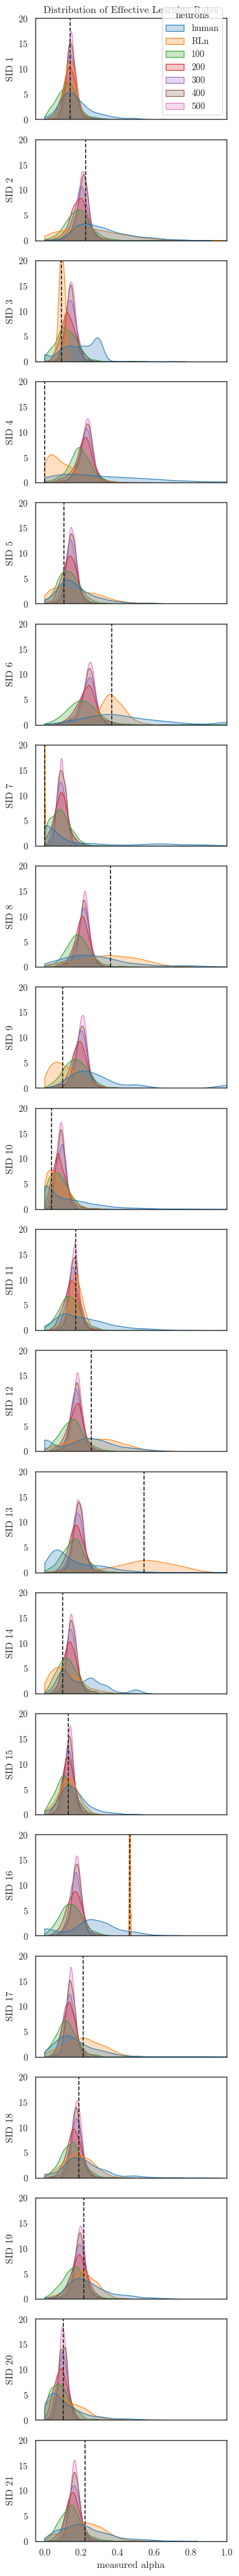

In [28]:
sids = human['sid'].unique()
fig, axes = plt.subplots(nrows=len(sids), ncols=1, figsize=(4, 2*len(sids)), sharex=True)
for s, sid in enumerate(sids):
    sns.kdeplot(combined.query("sid==@sid"), x='alpha', hue='neurons', ax=axes[s],
                clip=[0, 1], palette=palette[:7], fill=True, common_norm=False)
    axes[s].set(ylabel=f"SID {sid}", ylim=[0, 20])
    axes[s].axvline(target_alphas[s], color='k', ls="--")
    if s>0: axes[s].get_legend().remove()
axes[0].set(title='Distribution of Effective Learning Rates')
axes[-1].set(xlabel='measured alpha', xlim=[-0.05, 1])
plt.tight_layout()
fig.savefig("plots/alpha_distributions_all_sids.jpg", dpi=600)